In [1]:
import os
import shutil
import glob
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

import splitfolders

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

tf.__version__

'2.5.0'

# Preprocess data

## Split data

In [220]:
should_prepare_data = True

train_sequential = True

train_residual = True

train_sequential_augmented = True

In [3]:
def prepare_data():
    
    dirpaths = []
    class_names = []
    
    # generate list with roots for folders
    for dirpath, folder, _ in os.walk('./data/flowers/'):
        dirpaths.append(dirpath)
        class_names.append(folder)
    
    class_names = class_names[0]
        
    j = 0
    
    # loop through roots of image folders
    for dirpath in dirpaths[1:]:

        dst_dir = './data/input_flowers'

        if not os.path.exists(dst_dir):
            os.mkdir(dst_dir)

        i = 1  # no. of image

        for jpg_file in glob.iglob(os.path.join(dirpath, '*.jpg')):

            img_path = os.path.join(dst_dir, class_names[j])

            if not os.path.exists(img_path):
                os.mkdir(img_path)

            new_name = f'{class_names[j]}/{j}_{i}.jpg'

            shutil.copy(jpg_file, os.path.join(dst_dir, new_name))

            i += 1

        j += 1

    # split images to train/val/test folders
    splitfolders.ratio('./data/input_flowers', output='./data/output_flowers', seed=1337, ratio=(.7, .15, .15))
    
    return class_names

In [4]:
if should_prepare_data:
    prepare_data()

Copying files: 4317 files [00:00, 7228.01 files/s]


## Count images of each class and display chart

In [198]:
def get_count_of_images(folder_paths):
    
    '''
    Counts number of files for every class in train/validation/test sets.
    Returns DataFrame.
    
    Arguments:
    folder_paths --- path to train/val/test which must contain folders of each class
                      e.g. './data/train'
    '''
    
    dict_count = {}
     
    for dir_path in folder_paths:
    
        dir_name = os.path.basename(os.path.normpath(dir_path))
        dict_count[dir_name] = {}
    
        for root, dirs, files in os.walk(dir_path):

            if len(files) > 0:

                class_name = os.path.basename(os.path.normpath(root))
                count = len(files)

                dict_count[dir_name][class_name] = count
    
    df = pd.DataFrame(dict_count)
    
    if len(dict_count) > 1:
        df['total']= df.sum(axis=1)
                
    return df

In [199]:
split_folders = ['./data/output_flowers/train', './data/output_flowers/val', './data/output_flowers/test']

df = get_count_of_images(split_folders)

df

,train,val,test,total
tulip,688,147,149,984
rose,548,117,119,784
dandelion,736,157,159,1052
sunflower,513,109,111,733
daisy,534,114,116,764


In [8]:
def display_graph_of_images_count(dataframe):
    
    ax = dataframe.plot(kind='bar', figsize=(12, 8), title='Images count per class',
                        xlabel='Class', ylabel='Count', legend=False, fontsize=12)
    
    ax.legend(fontsize=12)

    for i in range(len(dataframe.columns)):
        ax.bar_label(ax.containers[i], label_type='edge', rotation=90, fontsize=12, padding=3)

    ax.margins(y=0.1)

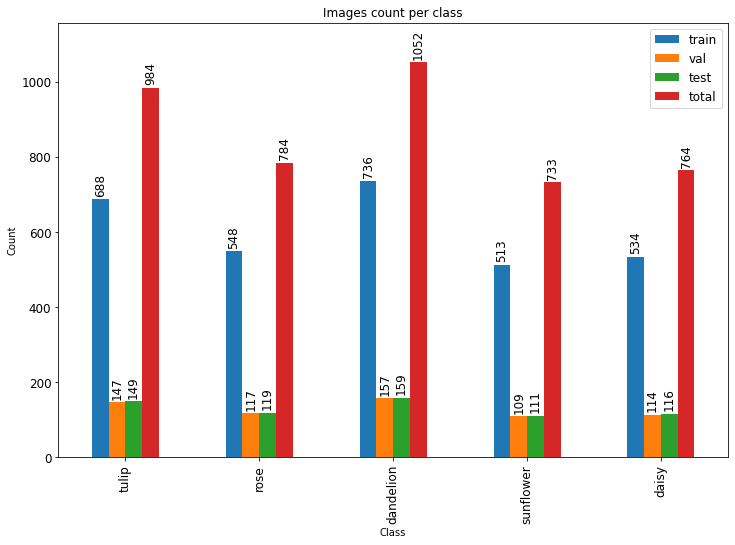

In [9]:
display_graph_of_images_count(df)

# Define train/val/test sets

In [15]:
batch_size = 32
img_height = 240
img_width = 240

train_dir = './data/output_flowers/train/'
val_dir = './data/output_flowers/val/'
test_dir = './data/output_flowers/test/'

In [16]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )

Found 3019 files belonging to 5 classes.


In [17]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )


Found 644 files belonging to 5 classes.


In [18]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )


Found 654 files belonging to 5 classes.


In [19]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

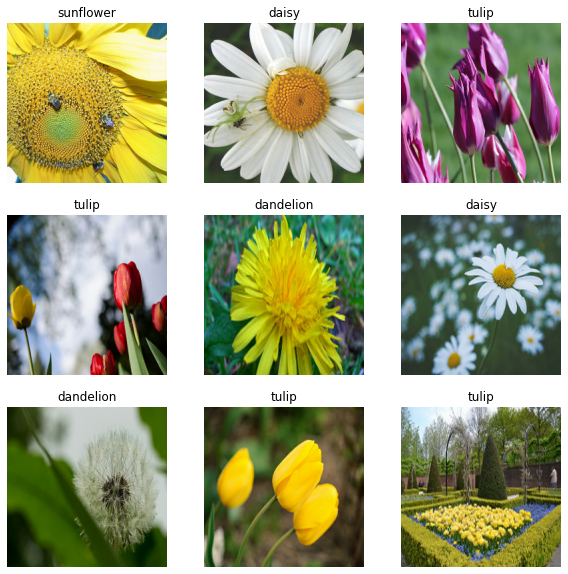

In [20]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Data augmentation

In [21]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,
        shear_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='sparse')

Found 3019 images belonging to 5 classes.
Found 644 images belonging to 5 classes.


# Deep learning models

## Sequential

In [22]:
def get_model(num_classes, dropout_rate=0.5):
    model = tf.keras.Sequential([

        tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        
        layers.Conv2D(32, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),

        layers.Conv2D(32, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),
        
        layers.Conv2D(64, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),      
        
        layers.Conv2D(128, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),      
        
        layers.Conv2D(128, (3,3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D(),          

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes)  
    ])
    
    return model

In [23]:
model = get_model(5)
    
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 240, 240, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 240, 240, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 240, 240, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 120, 120, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0

In [24]:
# Callbacks

def best_val_acc_callback(filepath):
    
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    return checkpoint_callback


In [25]:
epochs = 50

checkpoint_path = './saved_weights/flowers/flowers_sequential_model'

best_val_acc = best_val_acc_callback(checkpoint_path)

if train_sequential:
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[best_val_acc]
    )

Epoch 1/50
95/95 [==============================] - 33s 321ms/step - loss: 1.5577 - accuracy: 0.3501 - val_loss: 1.2650 - val_accuracy: 0.4286
Epoch 2/50
95/95 [==============================] - 30s 318ms/step - loss: 1.2299 - accuracy: 0.4833 - val_loss: 1.0312 - val_accuracy: 0.5947
Epoch 3/50
95/95 [==============================] - 30s 316ms/step - loss: 1.0983 - accuracy: 0.5648 - val_loss: 0.9298 - val_accuracy: 0.6429
Epoch 4/50
95/95 [==============================] - 30s 316ms/step - loss: 1.0008 - accuracy: 0.6095 - val_loss: 0.8854 - val_accuracy: 0.6475
Epoch 5/50
95/95 [==============================] - 30s 315ms/step - loss: 0.9583 - accuracy: 0.6154 - val_loss: 0.9656 - val_accuracy: 0.6025
Epoch 6/50
95/95 [==============================] - 30s 316ms/step - loss: 0.9295 - accuracy: 0.6433 - val_loss: 0.8480 - val_accuracy: 0.6646
Epoch 7/50
95/95 [==============================] - 30s 320ms/step - loss: 0.9068 - accuracy: 0.6641 - val_loss: 0.8009 - val_accuracy: 0.6941

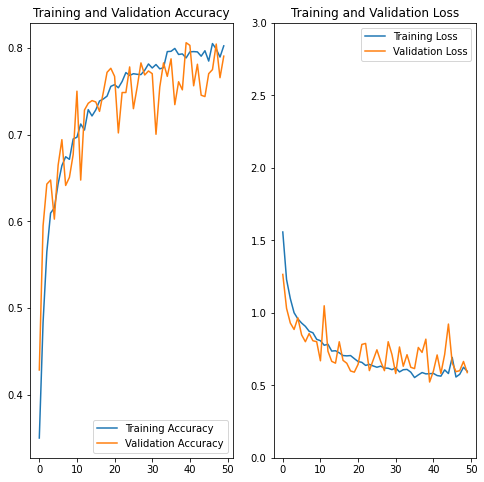

In [26]:
if train_sequential:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.ylim((0, 3))
    plt.show()

In [27]:
model.load_weights('./saved_weights/flowers/flowers_sequential_model')

In [28]:
model.evaluate(test_ds)

21/21 [==============================] - 1s 25ms/step - loss: 0.5262 - accuracy: 0.8073


[0.5262038707733154, 0.8073394298553467]

## Residual 

In [29]:
def conv2d_block(input_tensor, n_filters):
    
    x = input_tensor
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    x = layers.MaxPooling2D()(x)
    
    return x
    

In [30]:
def residual_block(input_tensor, n_filters):
    
    block_1 = conv2d_block(input_tensor, n_filters=n_filters)
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(block_1)
    
    x = layers.Conv2D(n_filters, (3,3), padding='same', activation='relu')(x)
    
    x = layers.add([block_1, x])
    
    return x

In [36]:
def get_res_model(num_classes, filters_conv2d_blocks):
    
    inputs = layers.Input(shape=(img_height, img_width, 3))
    
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
    
    for num_filters in filters_conv2d_blocks:
        x = residual_block(input_tensor=x, n_filters=num_filters)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(num_classes)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="residual_model")
    
    return model

In [37]:
model_res = get_res_model(5, [32, 64, 128, 256, 512])
model_res.summary()

Model: "residual_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 240, 240, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 240, 240, 32) 896         rescaling_2[0][0]                
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 240, 240, 32) 9248        conv2d_25[0][0]                  
_____________________________________________________________________________________

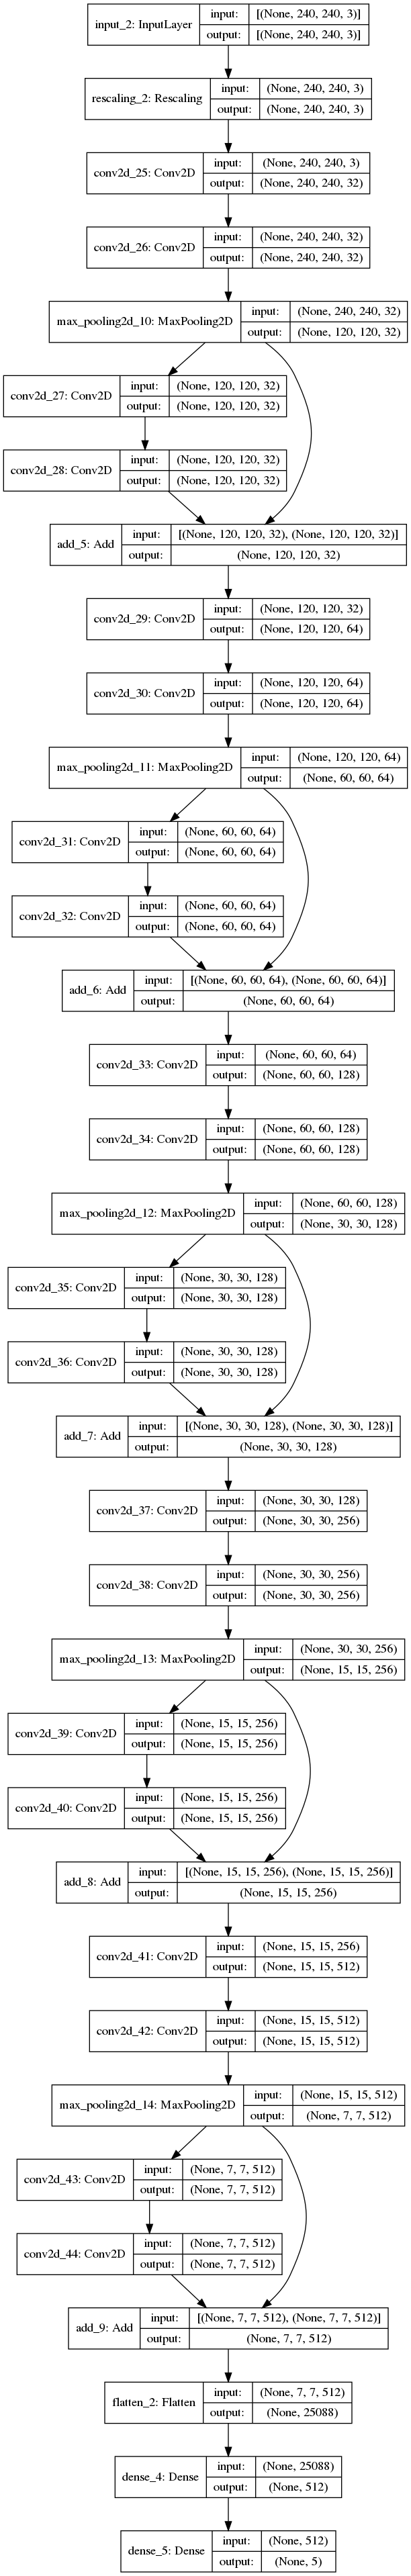

In [38]:
tf.keras.utils.plot_model(model_res, "res_model.png", show_shapes=True)


In [39]:
model_res.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
epochs = 50

checkpoint_path = './saved_weights/flowers/flowers_residual_model'

best_val_acc = best_val_acc_callback(checkpoint_path)

if train_residual:
    
    history_res = model_res.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            callbacks=[best_val_acc]
    )

Epoch 1/50
95/95 [==============================] - 36s 335ms/step - loss: 12.5980 - accuracy: 0.2428 - val_loss: 1.9816 - val_accuracy: 0.2438
Epoch 2/50
95/95 [==============================] - 30s 318ms/step - loss: 1.7044 - accuracy: 0.2541 - val_loss: 1.5812 - val_accuracy: 0.2795
Epoch 3/50
95/95 [==============================] - 31s 328ms/step - loss: 1.5505 - accuracy: 0.3094 - val_loss: 1.4095 - val_accuracy: 0.3168
Epoch 4/50
95/95 [==============================] - 32s 338ms/step - loss: 1.3694 - accuracy: 0.3935 - val_loss: 1.2816 - val_accuracy: 0.4224
Epoch 5/50
95/95 [==============================] - 32s 337ms/step - loss: 1.2789 - accuracy: 0.4296 - val_loss: 1.1978 - val_accuracy: 0.4752
Epoch 6/50
95/95 [==============================] - 32s 339ms/step - loss: 1.2254 - accuracy: 0.4823 - val_loss: 1.1222 - val_accuracy: 0.5357
Epoch 7/50
95/95 [==============================] - 32s 335ms/step - loss: 1.1651 - accuracy: 0.5416 - val_loss: 1.3564 - val_accuracy: 0.470

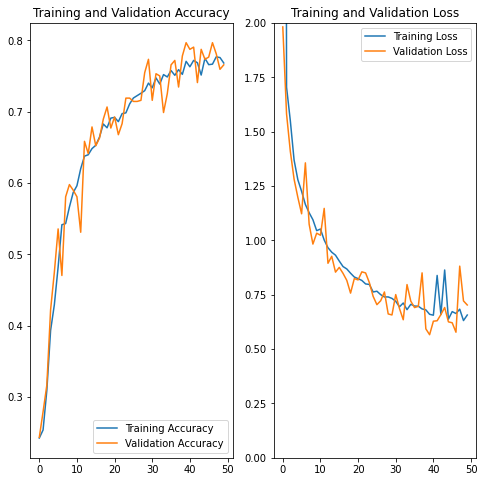

In [41]:
def display_plots(history_var):
    acc = history_var.history['accuracy']
    val_acc = history_var.history['val_accuracy']

    loss = history_var.history['loss']
    val_loss = history_var.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.ylim((0, 2))
    plt.show()
    
    
if train_residual:
    display_plots(history_res)

In [42]:
model_res.load_weights('./saved_weights/flowers/flowers_residual_model')

In [43]:
model_res.evaluate(test_ds)

21/21 [==============================] - 2s 106ms/step - loss: 0.5478 - accuracy: 0.7859


[0.5478487014770508, 0.785932719707489]

## Model evaluation

https://github.com/wcipriano/pretty-print-confusion-matrix

In [56]:
# ! pip install pretty-confusion-matrix

In [45]:
from sklearn.metrics import classification_report
from pretty_confusion_matrix import pp_matrix

In [66]:
def display_heatmap_for_classification(path_to_test_dir, predictive_model):
    
    test_data = tf.keras.preprocessing.image_dataset_from_directory(
        path_to_test_dir,
        labels='inferred',
        label_mode='categorical',
        image_size=(img_height,img_width),
        batch_size=batch_size)

    predictions = np.array([])
    
    labels =  np.array([])

    for x, y in test_data:

        predictions = np.concatenate([predictions, np.argmax(predictive_model.predict(x), axis=-1)])
        
        labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

    matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

    df_matrix = pd.DataFrame(matrix, index = [i for i in test_data.class_names],
                      columns = [i for i in test_data.class_names])

    pp_matrix(df_matrix, cmap="magma")

Found 654 files belonging to 5 classes.


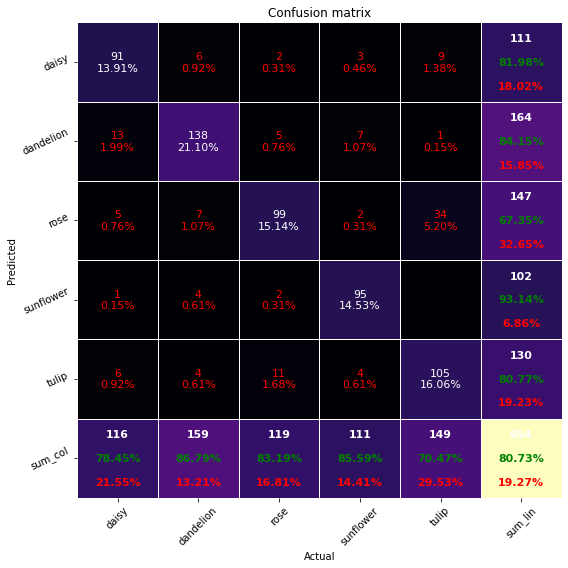

In [69]:
display_heatmap_for_classification(path_to_test_dir=test_dir, predictive_model=model)

# Generate and save new images

Section based on [tutorial](https://newbedev.com/how-to-save-resized-images-using-imagedatagenerator-and-flow-from-directory-in-keras).

In [87]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import preprocess_input    


In [113]:
from scipy import ndimage

In [230]:
def generate_new_image(img_path, save_path, gen_batch_size):
    
    if not os.path.exists(save_path):
            os.mkdir(save_path)
    
    # initialize image generator
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range=10,
            shear_range=0.2,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True)
    
    image = np.expand_dims(tf.keras.preprocessing.image.load_img(img_path), 0)
    
    datagen.fit(image)
    
    for x, val in zip(datagen.flow(
        image,                    
        save_to_dir=save_path,     
        save_prefix='aug',        
        save_format='jpg'), range(gen_batch_size - 1)) :    
        
            pass



In [231]:
import itertools

class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

def generate_and_save_transformed_images(num_images, save_dir_path):
    
    '''
    Generates and saves transformed images.
    
    Args:
        num_images(int) = number of images per each class to be transformed

    '''
    
    if not os.path.exists(save_dir_path):
            os.mkdir(save_dir_path)
    
    for name in class_names:

        for root, _, files in os.walk(f'./data/output_flowers/train/{name}'):

            i = 0

            for file in itertools.cycle(files):

                generate_new_image(
                    img_path=f'{root}/{file}', 
                    save_path=f'{save_dir_path}/{name}',
                    gen_batch_size=1)

                i += 1

                if i == num_images:
                    break

In [240]:
save_path = './data/output_flowers/train_augmented'

if not os.path.exists(save_path):
    
    generate_and_save_transformed_images(800, save_dir_path=save_path)

In [241]:
df_aug = get_count_of_images(['./data/output_flowers/train_augmented/'])

In [242]:
df_aug

,train_augmented
daisy,770
dandelion,765
rose,760
sunflower,771
tulip,759


In [243]:
df_aug_con = pd.concat([df_aug, df[['val', 'test']]], axis=1)
df_aug_con['total']= df_aug_con.sum(axis=1)
df_aug_con

,train_augmented,val,test,total
daisy,770,114,116,1000
dandelion,765,157,159,1081
rose,760,117,119,996
sunflower,771,109,111,991
tulip,759,147,149,1055


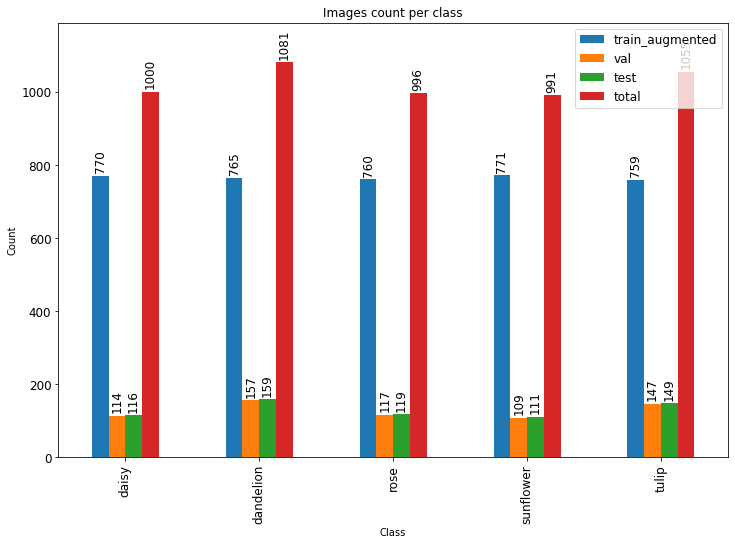

In [244]:
display_graph_of_images_count(df_aug_con)

## Train model on generated images

In [245]:
train_ds_augmented = tf.keras.preprocessing.image_dataset_from_directory(
    './data/output_flowers/train_augmented/',
    label_mode='int',
    batch_size=batch_size,
    image_size=(img_height, img_width)
    )

Found 3825 files belonging to 5 classes.


In [246]:
model_aug = get_model(5)

model_aug.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_aug.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_9 (Rescaling)      (None, 240, 240, 3)       0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 240, 240, 32)      896       
_________________________________________________________________
activation_35 (Activation)   (None, 240, 240, 32)      0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 120, 120, 32)      0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 120, 120, 32)      9248      
_________________________________________________________________
activation_36 (Activation)   (None, 120, 120, 32)      0         
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 60, 60, 32)       

In [ ]:
epochs = 20

checkpoint_path = './saved_weights/flowers/flowers_sequential_model_augmented'

best_val_acc = best_val_acc_callback(checkpoint_path)

if train_sequential_augmented:
    
    history_augmented = model_aug.fit(
        train_ds_augmented,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=[best_val_acc]
    )

Epoch 1/20
120/120 [==============================] - 7s 55ms/step - loss: 1.4579 - accuracy: 0.3759 - val_loss: 1.3093 - val_accuracy: 0.4612
Epoch 2/20
120/120 [==============================] - 6s 51ms/step - loss: 1.1766 - accuracy: 0.5359 - val_loss: 1.0956 - val_accuracy: 0.5326
Epoch 3/20
120/120 [==============================] - 6s 52ms/step - loss: 1.0044 - accuracy: 0.6120 - val_loss: 2.3135 - val_accuracy: 0.2888
Epoch 4/20
120/120 [==============================] - 7s 55ms/step - loss: 0.9271 - accuracy: 0.6554 - val_loss: 1.4887 - val_accuracy: 0.5543
Epoch 5/20
120/120 [==============================] - 7s 54ms/step - loss: 0.8251 - accuracy: 0.6892 - val_loss: 1.2664 - val_accuracy: 0.5932
Epoch 6/20
120/120 [==============================] - 6s 52ms/step - loss: 0.7195 - accuracy: 0.7213 - val_loss: 1.2293 - val_accuracy: 0.6289
Epoch 7/20
120/120 [==============================] - 6s 51ms/step - loss: 0.6070 - accuracy: 0.7799 - val_loss: 1.4487 - val_accuracy: 0.5870

In [ ]:
display_plots(history_augmented)

In [ ]:
model_aug.load_weights('./saved_weights/flowers/flowers_sequential_model_augmented')

model_aug.evaluate(test_ds)